<a href="https://colab.research.google.com/github/hyunshoon/bitcoin_price_prediction_with_SNS_sentiment/blob/main/comments_EDA_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reddit comments EDA
1. Setting
2. data load, pre-processing
3. Sentiment EDA using VADER
4. Sentiment EDA using Bert
5. EDA between sentiment and price


# Setting

In [ ]:
!pip install pysentimiento
!pip install transformers

     |████████████████████████████████| 312 kB 5.1 MB/s 
     |████████████████████████████████| 175 kB 31.4 MB/s 
     |████████████████████████████████| 4.2 MB 39.7 MB/s 
     |████████████████████████████████| 212 kB 40.9 MB/s 
     |████████████████████████████████| 1.1 MB 31.9 MB/s 
     |████████████████████████████████| 136 kB 38.7 MB/s 
     |████████████████████████████████| 84 kB 1.8 MB/s 
     |████████████████████████████████| 127 kB 37.8 MB/s 
     |████████████████████████████████| 6.6 MB 31.5 MB/s 
     |████████████████████████████████| 596 kB 37.2 MB/s 
     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 144 kB 36.6 MB/s 
     |████████████████████████████████| 271 kB 38.4 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=7b11f780d5e16a1816ab755a2153a892d188e1cd1d1984c66e77ae71c7658c4b
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7a

In [ ]:
import tensorflow as tf

from google.colab import drive
import re, os
from sklearn.metrics import confusion_matrix
import sklearn.metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from transformers import pipeline
from pysentimiento import create_analyzer

from tqdm.notebook import tqdm
import pickle
import time

from transformers import BertConfig, RobertaForSequenceClassification, pipeline, BertweetTokenizer
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
drive.mount('/content/drive')
path_capstone = '/content/drive/MyDrive/Colab Notebooks/capstone/data/'

#Bert setting
config = BertConfig.from_json_file('/content/drive/MyDrive/Colab Notebooks/capstone/test_trainer/config.json')
model = RobertaForSequenceClassification(config)
state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/capstone/test_trainer/pytorch_model.bin')
model.load_state_dict(state_dict)
model.eval()
tokenizer = BertweetTokenizer.from_pretrained("vinai/bertweet-base")
classifier = pipeline("text-classification", model = model, tokenizer=tokenizer, device = 0)#GPU 사용
# classifier = pipeline("text-classification", model = model, tokenizer=tokenizer)

Mounted at /content/drive


Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# comment count

### load comment data

In [ ]:
start = '2018-01-02'
end = '2022-02-28'

df_btc = pd.read_csv(f'{path_capstone}data_final_bitcoin.csv', index_col=0)
df_btc = df_btc.loc[:,start:end]
df_btc.fillna(0, inplace=True)

df_btc_top = pd.read_csv(f'{path_capstone}top_comment_bitcoin_cl.csv', index_col=0)
df_btc_top = df_btc_top.loc[:,start:end]
df_btc_top.fillna(0, inplace=True)

df_btc_second = pd.read_csv(f'{path_capstone}second_comment_bitcoin_cl.csv', index_col=0)
df_btc_second = df_btc_second.loc[:,start:end]
df_btc_second.fillna(0, inplace=True)

df_crypto_top = pd.read_csv(f'{path_capstone}top_comment_crypto_cl.csv', index_col=0)
df_crypto_top = df_crypto_top.loc[:,start:end]
df_crypto_top.fillna(0, inplace=True)

df_total = df_btc.append(df_crypto_top, ignore_index=True)
df_total = df_total.loc[:,start:end]

# df_top = df_btc_top.append(df_crypto_top, ignore_index = True)
# df_top = df_top.loc[:,start:end]
df_btc.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-09,2018-01-10,2018-01-11,2018-01-12,...,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,2022-02-25,2022-02-26,2022-02-27,2022-02-28
0,"""Ten years in, nobody has come up with a use f...",2018 is gonna be a good year.,News about rockets must be check http://al...,10 hours for a transfer to binance and countin...,17.36k as of right now :),***DON'T PANIC ON COINMARKETCAP!***\n\nThey ju...,.. There ARE numerous teams working on infrast...,!,Special thanks to everyone selling me bitcoin...,Do not sell for a loss...either hold or buy more.,...,$ 25K,Username checks out,!LNTIP 1024,*prepares his submarine*,"""Its time to buy when there's blood on the str...",$8m short just got nuked. Some real spice today.,"""It is no coincidence that the century of tota...",Agreed. But when.,*$500K next year.,$30k to $50k is the new $5k to $10k range
1,"14,666 yeaaaaah :D","3 weeks, still waiting...",5k,100% agree on this one!,17k-18k then 20k by end of the week,2018 will be big for Bitcoin!,11k...,!,17,Four times of whatever the price of one bitcoi...,...,100% BTC. No stonks.,"""$320k so far""\n\n-Homer Simpson","$38,000 is the new $3,800",30k coming,15 times a day are rookie numbers.,*I didn't hear a bell* meme,"""You'll be down half your net worth in three m...","And in parallel, a shite FUD piece on energy use.",4.0 million,*Breaking*: Bitcoin is the hardest money on ea...
2,15k we made itt!!!!!!!!!!!!!,3 weeks. still waiting.,A digital currency.,100% per day! Every day! You must be a trading...,"Absolutely possible, it‘s not like those guys ...",>I believe its good time to buy now\n\n,15k for me...,"""2018 will be a great year for crypto"" they sa...",All this FUD made me hungry,Here we are. Friday again.\nTOO THE MOOOOOON!!...,...,100k by the end of the year.,"""Superb reporter"" sauce sounds like Grey Poupon",*Pution*,"A day like this may never come. Nobody knows, ...",29k mh guess\n\nI'm happy to be wrong for once!,2 thoughts:\n\nFCK Putin\n\nFCK Xi\n\nHODL!,50k bound !!!!!!,"At the worst days, pray for Ukraine that thing...",713 represent playa!,*Oh wise prophet…*
3,"2-4 business days, I think. That can be 7 or m...",Any idea if this site is legit place to buy ha...,Above 15k at least it seems,16k again baby!,Ate that wall hella fast,BTC on discount before liftoff!!!! Buy buy buy,35k. Shot in the dark.,"*turns on fan, vomit flys back in your face*",And now your watch begins,I think they will face no consequences for it ...,...,25% BTC 75% stocks.,1 RedCoin = 1 RedCoin,*turn around... every now and then I dip a lit...,Another 100 million sats off the market 🔥🚀,40 and holding would feel good.,"200WMA is getting higher, i hope we never ret...","50k would be nice, but i dont see that happeni...",BTC to $300k.,"Always have been, and the people holding it ar...",*This time* it's never going below $40k again
4,Chart Theory is useless. Nobody knows.,Been waiting about a month lmao good luck,Bitcoin Storm damn,17k incoming !!!,Back above 17k,Because I bought $50 last night.,> When will bitcoin cross $20 k\n\nFebruary\n\...,*vomits*,"Assuming 12900 is the low for today, BTC is up...",I would say 1. And 2. Are good options,...,40k stable coin,10 k is the flag amount,.25%,Ban hammer comin’ for you,"A large number of Ukrainians us Bitcoin, turn ...",Ain't so bad! - Rocky Balboa,A major crash was when it went from 18 to 3 fo...,Better to just keep a hodl on just whatever yo...,And the winner is Bitcoin.,1 BTC = 3.2 milllion rubles


## count daily comment number
일별 댓글 수 분포 확인

In [ ]:
def count_text_num(df):#count daily comment num
  day_cnt = []
  for i in range(len(df.columns)):
    cnt = 0
    for j in range(len(df)):
      text = df.iloc[j,i]
      if text =='[deleted]' or text == 0: continue #NaN, [deleted]되있는 문장 스킵
      cnt +=1
    if cnt==0:
      print(f'{df.columns[i]}<- comment 0개')
    day_cnt.append(cnt)
  return day_cnt

In [ ]:
print('btc_total')
btc_cnt = count_text_num(df_btc)
print('btc_top')
btc_cnt_top = count_text_num(df_btc_top)
print('btc_second')
btc_cnt_second = count_text_num(df_btc_second)
print('crypto_top')
crypto_cnt_top = count_text_num(df_crypto_top)
print('total')
total_cnt = count_text_num(df_total)

In [ ]:
plt.subplot(5, 1, 1)
plt.hist(btc_cnt, bins= range(0,1000,10))
plt.subplot(5, 1, 2)
plt.hist(btc_cnt_top, bins= range(0,1000,10))
plt.subplot(5, 1, 3)
plt.hist(btc_cnt_second, bins= range(0,1000,10))
plt.subplot(5, 1, 4)
plt.hist(crypto_cnt_top, bins= range(0,1000,10))
plt.subplot(5, 1, 5)
plt.hist(total_cnt, bins= range(0,1000,10))
plt.show()

# sentiment EDA

In [ ]:
#LABEL_0, 1, 2: 부정, 중립, 긍정
print(classifier('fuck'))
print(classifier('fsafdsdfsdfg'))
print(classifier('I ate chikens'))
print(classifier('BTC drop'))
print(classifier('HODL'))
print(classifier('good'))


[{'label': 'LABEL_0', 'score': 0.999816358089447}]
[{'label': 'LABEL_1', 'score': 0.9999293088912964}]
[{'label': 'LABEL_1', 'score': 0.9999439716339111}]
[{'label': 'LABEL_0', 'score': 0.9998641014099121}]
[{'label': 'LABEL_2', 'score': 0.9999761581420898}]
[{'label': 'LABEL_2', 'score': 0.9999785423278809}]


### def

In [ ]:
def sent(x):#BERT
    bert_dict = classifier(x)
    if bert_dict[0]['label'] == 'LABEL_0':
        return 'negative'
    elif bert_dict[0]['label'] == 'LABEL_1':
        return 'neutral'
    elif bert_dict[0]['label'] == 'LABEL_2':
        return 'positive'

In [ ]:
def filtering(series): #text filtering
  cleaned = []
  for text in series: 
    if text =='[deleted]' or text == 0: 
      continue #NaN, [deleted]되있는 문장 스킵
    if re.match('http', text) or text.find('!gif') != -1:
      continue
    if len(text)>=128: continue # 버트윗이 최대 128까지 됌.
    length = len(text.split())#20단어 이상 문장들, 물음표로 끝나는 문장 제거
    if length >20 or text[-1]=='?': 
      print('long sentence or ends with question mark')
      print(text)
      continue
    cleaned.append(text)
  return cleaned

In [ ]:
#감성점수 비율 계산
def ratio(li):
  neu = 0
  pos = 0
  neg = 0
  for s in li:
    if s == 'neutral':
      neu += 1
    elif s== 'positive':
      pos += 1
    else:
      neg += 1
  total = pos + neu + neg
  if total!=0:
    return [pos/total, neu/total, neg/total]
  else:
    return [0,0,0]

In [ ]:
def make_features(df):
  df['EMA_short'] = df.pos.ewm(span = 12).mean()
  df['EMA_long'] = df.pos.ewm(span = 26).mean()
  df['MACD'] = df.EMA_short - df.EMA_long
  df['MACD_OSC'] = df.MACD - df.pos.ewm(span = 9).mean()#macd osc
  df['pos-neg'] = df.pos - df.neg
  return df

In [ ]:
def make_day_score(df):
  day = []
  date = []

  for i in range(0,len(df.columns)):
    cleaned = filtering(df.iloc[:,i])
    print(i)
    date.append(df.columns[i].replace('-',''))
    sentiments = []
    for text in cleaned:# 정제된 데이터에서 긍/중/부 판단
      # sentiments.append(sent(text))
      try:
        sentiments.append(sent(text))
      except RuntimeError as e:
        print(i, e)
        print(text)
    sent_features = ratio(sentiments)
    day.append(sent_features)
  day = pd.DataFrame(day, columns=['pos', 'neu', 'neg'])
  day['day'] = date
  for i in range(len(day)):
    day.loc[i,'day'] = datetime.strptime(day.loc[i,'day'], '20%y%m%d')
  day.set_index('day', inplace =True)

  return make_features(day)

### sentiment distribution

In [ ]:
df_total.fillna(0, inplace = True)

In [ ]:
sent_btc = make_day_score(df_btc)
sent_btc.to_csv(f'{path_capstone}sent_btc_bert.csv')
sent_btc_top = make_day_score(df_btc_top)
sent_btc_top.to_csv(f'{path_capstone}sent_btc_top_bert.csv')
sent_btc_second = make_day_score(df_btc_second)
sent_btc_second.to_csv(f'{path_capstone}sent_btc_second_bert.csv')
sent_crypto_top =  make_day_score(df_crypto_top)
sent_total = make_day_score(df_total)
sent_total.to_csv(f'{path_capstone}sent_total_bert.csv')

print(sent_btc.describe())
print(sent_btc_top.describe())
print(sent_btc_second.describe())
print(sent_crypto_top.describe())
print(sent_total.describe())

In [ ]:
sent_btc = pd.read_csv(f'{path_capstone}sent_btc_bert.csv')
sent_btc

,day,pos,neu,neg,EMA_short,EMA_long,MACD,MACD_OSC,pos-neg
0,2018-01-02,0.263158,0.578947,0.157895,0.263158,0.263158,0.000000,-0.263158,0.105263
1,2018-01-03,0.346154,0.500000,0.153846,0.308114,0.306252,0.001862,-0.307405,0.192308
2,2018-01-04,0.200000,0.466667,0.333333,0.265917,0.268077,-0.002160,-0.266645,-0.133333
3,2018-01-05,0.349206,0.404762,0.246032,0.292208,0.290757,0.001451,-0.291734,0.103175
4,2018-01-06,0.255814,0.534884,0.209302,0.282320,0.282654,-0.000333,-0.282401,0.046512
...,...,...,...,...,...,...,...,...,...
1501,2022-02-24,0.375494,0.296443,0.328063,0.373438,0.374615,-0.001177,-0.375207,0.047431
1502,2022-02-25,0.377778,0.244444,0.377778,0.374106,0.374849,-0.000743,-0.375523,0.000000
1503,2022-02-26,0.296296,0.296296,0.407407,0.362135,0.369030,-0.006895,-0.365978,-0.111111
1504,2022-02-27,0.461538,0.230769,0.307692,0.377428,0.375883,0.001545,-0.378029,0.153846


In [ ]:
def str_to_time(day):
  for i in range(len(day)):
    day.loc[i,'day'] = datetime.strptime(day.loc[i,'day'], '%Y-%m-%d')
  day.set_index('day', inplace = True)
  return day


In [ ]:
sent_btc = pd.read_csv(f'{path_capstone}sent_btc_bert.csv')
sent_btc_top = pd.read_csv(f'{path_capstone}sent_btc_top_bert.csv')
sent_btc_second = pd.read_csv(f'{path_capstone}sent_btc_second_bert.csv')
sent_crypto_top = pd.read_csv(f'{path_capstone}sent_crypto_top_bert.csv')
sent_total = pd.read_csv(f'{path_capstone}sent_total_bert.csv')


# Price data load

In [ ]:
!pip install ccxt

import ccxt
import time

     |████████████████████████████████| 2.7 MB 5.2 MB/s 
     |████████████████████████████████| 4.0 MB 30.1 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 291 kB 44.2 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
t = '2017-12-01 09:00:00' #btc 시작
start = int(time.mktime(datetime.strptime(t, '%Y-%m-%d %H:%M:%S').timetuple())*1000)#처음 데이터 가져올 때
def timestamp_to_str(time):  # 타임스탬프 문자열로 변환
    return str(time.year * 100000000 + time.month * 1000000 + time.day * 10000 + time.hour * 100 + time.minute)
days = 86400000
binance = ccxt.binance()
btc_ohlcv = binance.fetch_ohlcv("BTC/USDT", '1d', since = start, limit = 1000)
btc_ohlcv2 = binance.fetch_ohlcv("BTC/USDT", '1d', since = start + days*1000, limit = 1000)
df = pd.DataFrame(btc_ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df2 = pd.DataFrame(btc_ohlcv2, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
df2['datetime'] = pd.to_datetime(df2['datetime'], unit='ms')
df.set_index('datetime', inplace=True)
df2.set_index('datetime', inplace=True)

hist = df.append(df2)
hist.head()

,open,high,low,close,volume
datetime,,,,,
2017-12-02,10775.04,11190.00,10620.00,10890.01,4765.439757
2017-12-03,10902.69,11825.00,10500.00,11165.41,5346.636524
2017-12-04,11165.41,11600.00,10802.00,11579.00,4663.424562
2017-12-05,11571.03,11853.00,11447.68,11699.99,5550.732055
2017-12-06,11699.99,13615.23,11665.58,13550.05,6707.946319


# Relation between sentiment and price

### missing value

In [ ]:
def str_to_time(day):
  for i in range(len(day)):
    day.loc[i,'day'] = datetime.strptime(day.loc[i,'day'], '%Y-%m-%d')
  day.set_index('day', inplace = True)
  return day


In [ ]:
#결측치가 있는 날은 전날 값으로 감성점수 대체
def missing_day(day):
  last_day = day.index[-1]
  for i in range(len(day)):
    if day.index[i] == last_day:break
    if day.index[i]  + timedelta(days=1) != day.index[i+1]: #다음 날짜가 없다
      day.loc[day.index[i]  + timedelta(days=1)] = [day.iloc[i,0],day.iloc[i,1],day.iloc[i,2],day.iloc[i,3],day.iloc[i,4],
                                                    day.iloc[i,5],day.iloc[i,6],day.iloc[i,7]]
  day = day.sort_index()
  return day

In [ ]:
while True:
  first = sent_crypto_top.shape
  print(sent_btc.shape)
  print(sent_btc_top.shape)
  print(sent_btc_second.shape)
  print(sent_crypto_top.shape)
  sent_btc = missing_day(sent_btc)
  sent_btc_top = missing_day(sent_btc_top)
  sent_btc_second = missing_day(sent_btc_second)
  sent_crypto_top = missing_day(sent_crypto_top)
  sent_total = missing_day(sent_total)
  second = sent_crypto_top.shape
  print(sent_btc.shape)
  print(sent_btc_top.shape)
  print(sent_btc_second.shape)
  print(sent_crypto_top.shape)
  if first == second: break


(1506, 8)
(1506, 8)
(1502, 8)
(1442, 8)
(1516, 8)
(1516, 8)
(1516, 8)
(1497, 8)
(1516, 8)
(1516, 8)
(1516, 8)
(1497, 8)
(1517, 8)
(1517, 8)
(1517, 8)
(1507, 8)
(1517, 8)
(1517, 8)
(1517, 8)
(1507, 8)
(1518, 8)
(1518, 8)
(1518, 8)
(1510, 8)
(1518, 8)
(1518, 8)
(1518, 8)
(1510, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1513, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1513, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1515, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1515, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1517, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1517, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)
(1519, 8)


price data section fit

In [ ]:
print(sent_btc.shape)
print(hist.shape)
hist = hist.loc[sent_btc.index[0]:sent_btc.index[-1],:] # sent_btc와 start date, end date 통합
print(sent_crypto_top.shape)
print(hist.shape)
hist.join(sent_btc) #sent_df의 2022-01-02 ~ 2022-01-04까지 NaN 값

(1519, 8)
(1627, 5)
(1519, 8)
(1519, 5)


,open,high,low,close,volume,pos,neu,neg,EMA_short,EMA_long,MACD,MACD_OSC,pos-neg
datetime,,,,,,,,,,,,,
2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,0.263158,0.578947,0.157895,0.263158,0.263158,0.000000,-0.263158,0.105263
2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,0.346154,0.500000,0.153846,0.308114,0.306252,0.001862,-0.307405,0.192308
2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,0.200000,0.466667,0.333333,0.265917,0.268077,-0.002160,-0.266645,-0.133333
2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,0.349206,0.404762,0.246032,0.292208,0.290757,0.001451,-0.291734,0.103175
2018-01-06,16960.39,17143.13,16011.21,17069.79,18571.457508,0.255814,0.534884,0.209302,0.282320,0.282654,-0.000333,-0.282401,0.046512
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,37250.02,39843.00,34322.28,38327.21,120476.294580,0.375494,0.296443,0.328063,0.373438,0.374615,-0.001177,-0.375207,0.047431
2022-02-25,38328.68,39683.53,38014.37,39219.17,56574.571250,0.377778,0.244444,0.377778,0.374106,0.374849,-0.000743,-0.375523,0.000000
2022-02-26,39219.16,40348.45,38573.18,39116.72,29361.256800,0.296296,0.296296,0.407407,0.362135,0.369030,-0.006895,-0.365978,-0.111111


## Visualization

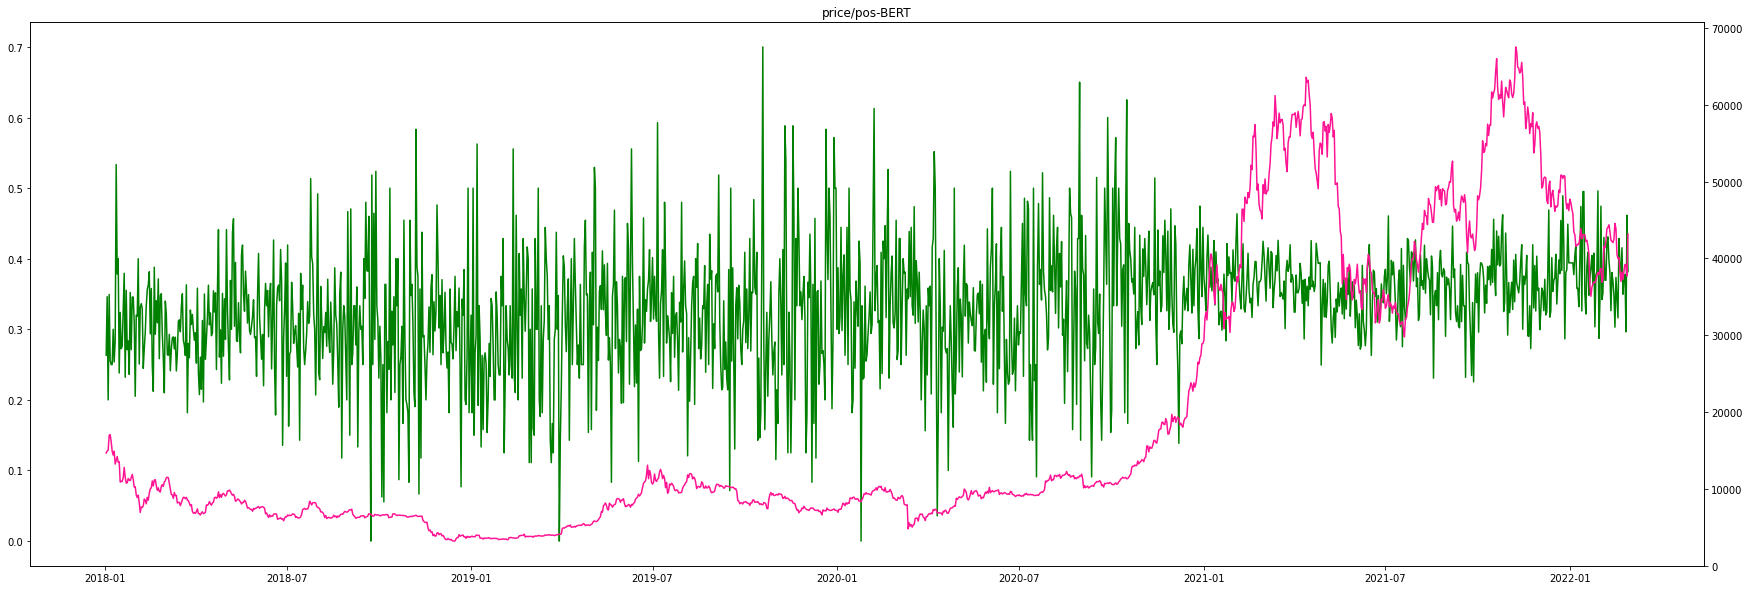

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
x = sent_btc.index
y1 = sent_btc.pos
y2 = hist['close']
ax1.plot(x, y1, color='green')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='deeppink')
plt.title('price/pos-BERT')
plt.show()

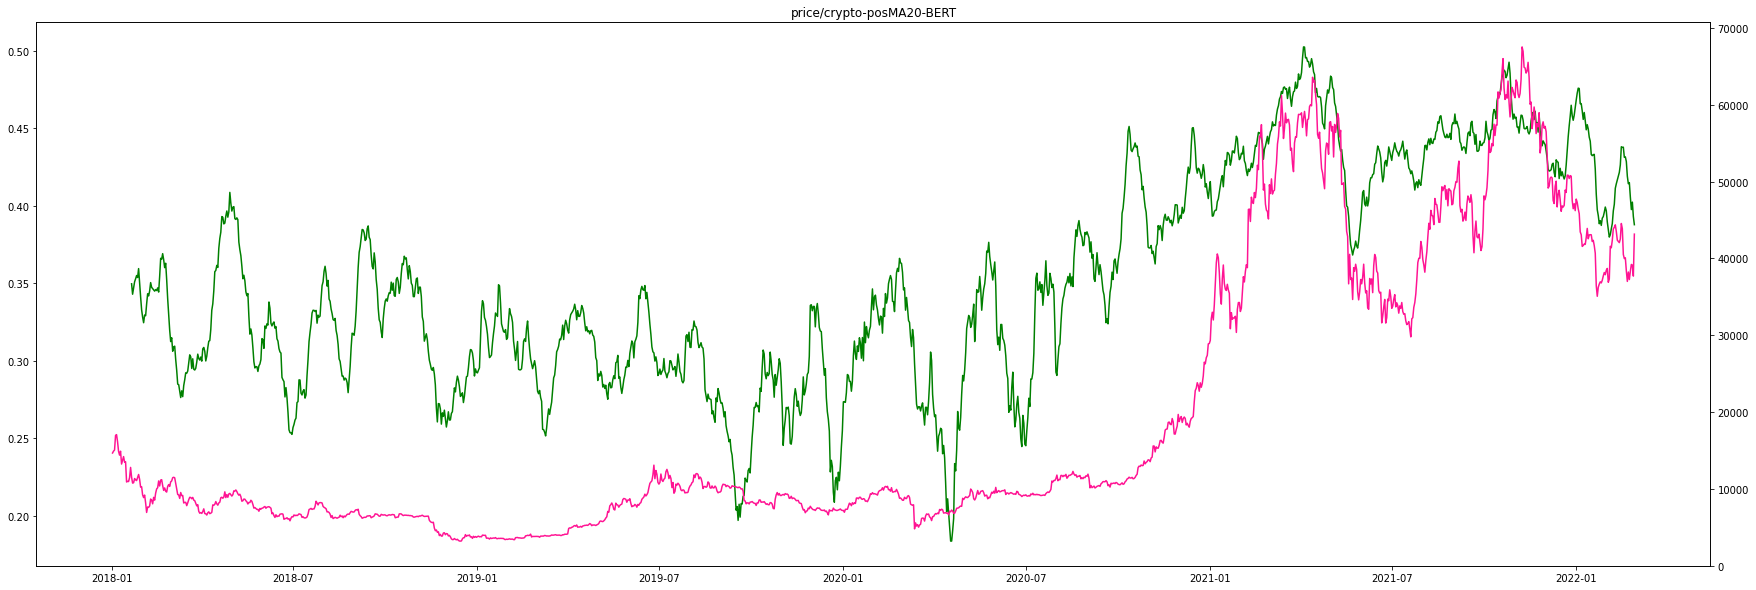

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
x = sent_crypto_top.index
y1 = sent_crypto_top.pos.rolling(window=20, min_periods=20).mean()
y2 = hist['close']
ax1.plot(x, y1, color='green')

ax2 = ax1.twinx()
ax2.plot(x, y2, color='deeppink')
plt.title('price/crypto-posMA20-BERT')
plt.show()

## Correlation

In [ ]:
#상관계수
def correlation(day, price):
  pos = np.corrcoef(day['pos'], price['close'])[0,1]
  neu = np.corrcoef(day['neu'], price['close'])[0,1]
  neg = np.corrcoef(day['neg'], price['close'])[0,1]
  pos_neg = np.corrcoef(day['pos-neg'], price['close'])[0,1]
  posMA20 = np.corrcoef(day.pos.rolling(window=20, min_periods=1).mean(), price['close'])[0,1]
  negMA20 = np.corrcoef(day.neg.rolling(window=20, min_periods=1).mean(), price['close'])[0,1]
  EMA_short = np.corrcoef(day['EMA_short'], price['close'])[0,1]
  EMA_long = np.corrcoef(day['EMA_long'], price['close'])[0,1]
  MACD = np.corrcoef(day['MACD'], price['close'])[0,1]
  MACD_OSC = np.corrcoef(day['MACD_OSC'], price['close'])[0,1]
  return pos, neu, neg, pos_neg,posMA20, negMA20, EMA_short, EMA_long, MACD, MACD_OSC

In [ ]:
sent_btc = sent_btc.fillna(0)
sent_btc_top = sent_btc_top.fillna(0)
sent_btc_second = sent_btc_second.fillna(0)
sent_crypto_top = sent_crypto_top.fillna(0)

In [ ]:
#가격 차트는 하루씩 미뤄서 
matrix_df = pd.DataFrame({
    'btc' : correlation(sent_btc[:-1], hist[1:]),
    'btc_top' :correlation(sent_btc_top[:-1], hist[1:]),
    'btc_second' : correlation(sent_btc_second[:-1], hist[1:]),
    'crypto_top' : correlation(sent_crypto_top[:-1], hist[1:]),
    'total' : correlation(sent_total[:-1], hist[1:])
})
matrix_df['sent_feature'] = ['pos', 'neu', 'neg', 'pos-neg', 'posMA20', 'negMA20', 'EMA_short',
                             'EMA_long', 'MACD', 'MACD_OSC']
matrix_df.set_index('sent_feature', inplace = True)
print('correlation between sentiment and price')
matrix_df

correlation between sentiment and price


,btc,btc_top,btc_second,crypto_top,total
sent_feature,,,,,
pos,0.258822,0.211006,0.176277,0.482808,0.390519
neu,-0.295291,-0.245081,-0.207099,-0.348879,-0.357508
neg,0.080672,0.064031,0.075774,-0.159772,-0.005251
pos-neg,0.107045,0.097255,0.064412,0.359737,0.236789
posMA20,0.673673,0.644395,0.582033,0.837264,0.786569
negMA20,0.208569,0.197503,0.227372,-0.376442,-0.045265
EMA_short,0.613153,0.562091,0.511083,0.806560,0.740541
EMA_long,0.711290,0.685347,0.616977,0.866917,0.814099
MACD,0.003840,-0.002278,0.010857,0.004692,0.001865


In [ ]:
matrix_df2 = pd.DataFrame({
    'btc' : correlation(sent_btc[:-1], hist[1:]),
    'btc_top' :correlation(sent_btc_top[:-1], hist[1:]),
    'btc_second' : correlation(sent_btc_second[:-1], hist[1:]),
    'crypto_top' : correlation(sent_crypto_top[:-1], hist[1:]),
    'total' : correlation(sent_total[:-1], hist[1:])
})
matrix_df2['sent_feature'] = ['pos', 'neu', 'neg', 'pos-neg', 'posMA20', 'negMA20', 'EMA_short',
                             'EMA_long', 'MACD', 'MACD_OSC']
matrix_df2.set_index('sent_feature', inplace = True)
print('correlation between sentiment(t) and price(t+1)')
matrix_df2

correlation between sentiment(t) and price(t+1)


,btc,btc_top,btc_second,crypto_top,total
sent_feature,,,,,
pos,0.258822,0.211006,0.176277,0.482808,0.390519
neu,-0.295291,-0.245081,-0.207099,-0.348879,-0.357508
neg,0.080672,0.064031,0.075774,-0.159772,-0.005251
pos-neg,0.107045,0.097255,0.064412,0.359737,0.236789
posMA20,0.673673,0.644395,0.582033,0.837264,0.786569
negMA20,0.208569,0.197503,0.227372,-0.376442,-0.045265
EMA_short,0.613153,0.562091,0.511083,0.806560,0.740541
EMA_long,0.711290,0.685347,0.616977,0.866917,0.814099
MACD,0.003840,-0.002278,0.010857,0.004692,0.001865
